<a href="https://colab.research.google.com/github/Grigoriy-D/strategies-1/blob/master/CryptoCurrency_Prediction_with_Artificial_Intelligence_V2_0_%5BGRU_Neural_Network%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation, Dense, Dropout, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
data = pd.read_feather("/content/drive/MyDrive/BTC_USDT_USDT-1h-futures.feather")[::-1]
data = data.iloc[:,0:6]
y = data.loc[:,['close']]
data = data.drop(['close','volume'],axis='columns')
print(data.head(5))
print(y.head(5))

                           date     open     high      low
35711 2024-04-21 09:00:00+00:00  64907.2  64970.4  64695.9
35710 2024-04-21 08:00:00+00:00  65108.0  65203.2  64900.0
35709 2024-04-21 07:00:00+00:00  65026.1  65145.7  64867.0
35708 2024-04-21 06:00:00+00:00  64997.4  65180.0  64899.2
35707 2024-04-21 05:00:00+00:00  65031.1  65218.0  64939.2
         close
35711  64880.1
35710  64907.2
35709  65108.0
35708  65026.1
35707  64997.4


In [39]:
data = data.set_index('date')
data.index = pd.to_datetime(data.index,unit='ns')
print(data.index)

DatetimeIndex(['2024-04-21 09:00:00+00:00', '2024-04-21 08:00:00+00:00',
               '2024-04-21 07:00:00+00:00', '2024-04-21 06:00:00+00:00',
               '2024-04-21 05:00:00+00:00', '2024-04-21 04:00:00+00:00',
               '2024-04-21 03:00:00+00:00', '2024-04-21 02:00:00+00:00',
               '2024-04-21 01:00:00+00:00', '2024-04-21 00:00:00+00:00',
               ...
               '2020-03-25 19:00:00+00:00', '2020-03-25 18:00:00+00:00',
               '2020-03-25 17:00:00+00:00', '2020-03-25 16:00:00+00:00',
               '2020-03-25 15:00:00+00:00', '2020-03-25 14:00:00+00:00',
               '2020-03-25 13:00:00+00:00', '2020-03-25 12:00:00+00:00',
               '2020-03-25 11:00:00+00:00', '2020-03-25 10:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=35712, freq=None)


In [40]:
aim = 'close'

In [41]:
data.shape

(35712, 3)

In [42]:
"""
X_train = data[:5000]
X_test = data[5000:]

y_train = y[:20000]
y_test = y[20000:]
print(y_test)
"""
interval_size = 800

# Создаем булев индекс для выбора каждого n-го интервала
indices = np.arange(len(data))
test_indices = (indices % interval_size) < (interval_size / 2)
train_indices = ~test_indices

# Разделяем данные на тренировочные и тестовые интервалами
X_train = data[train_indices]
X_test = data[test_indices]

y_train = y[train_indices]
y_test = y[test_indices]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('BTC/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

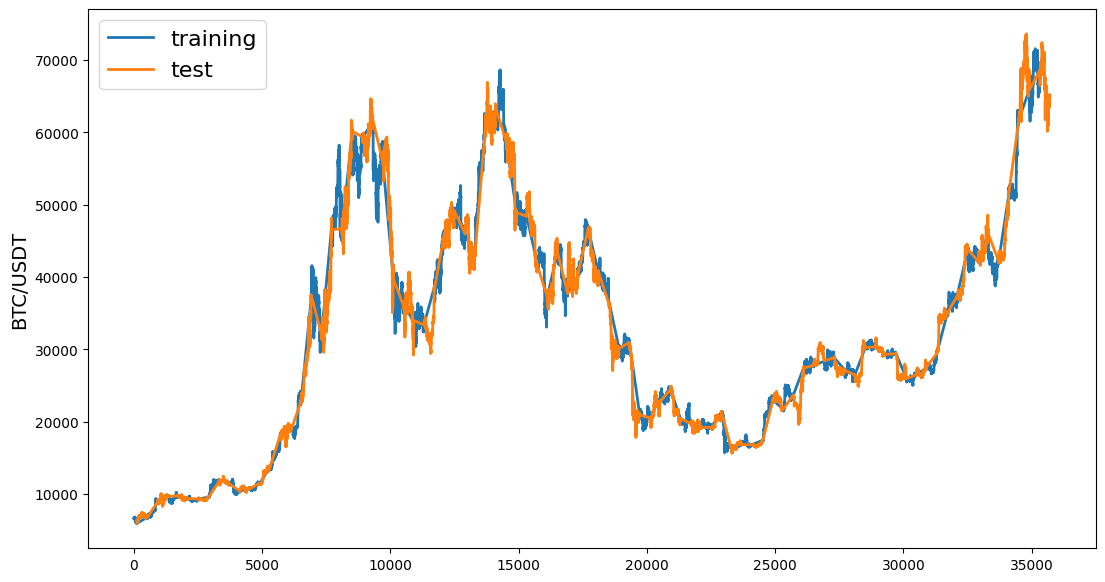

In [23]:
line_plot(y_train[aim], y_test[aim], 'training', 'test', title='')

In [25]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [26]:
X_train = normalise_zero_base(X_train)
X_test = normalise_zero_base(X_test)
y_train = normalise_zero_base(y_train)
y_test = normalise_zero_base(y_test)

In [44]:
import numpy as np
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test,axis=1)

#y_train = np.expand_dims(y_train, axis=1)
#y_test = np.expand_dims(y_test, axis=1)

In [45]:
X_train.shape

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (17712, 1, 3)
X_test shape: (18000, 1, 3)
y_train shape: (17712, 1)
y_test shape: (18000, 1)


In [15]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
from tensorflow import keras
#from tensorflow.keras.models import Sequential
# The GRU architecture
gruMODEL = Sequential()
# First GRU layer with Dropout regularisation
gruMODEL.add(GRU(
    units=1024,
    input_shape=(1,3),
    activation='PReLU',
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=True,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False,
    reset_after=True))
gruMODEL.add(Dropout(0.9))
# Second GRU layer
gruMODEL.add(GRU(
    units=2048,
    activation='PReLU',
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=True,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False,
    reset_after=True))
gruMODEL.add(Dropout(0.8))
# Third GRU layer
gruMODEL.add(GRU(
    units=4096,
    activation='PReLU',
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=True,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False,
    reset_after=True))
gruMODEL.add(Dropout(0.09))
# Fourth GRU layer
gruMODEL.add(GRU(
    units=512,
    activation='PReLU',
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=True,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False,
    reset_after=True))
gruMODEL.add(Dropout(0.09))
# The output layer
gruMODEL.add(Dense(units=1))
# Compiling the RNN
gruMODEL.compile(optimizer="sgd",loss='mean_squared_error')
gruMODEL.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 1, 1024)           3162112   
                                                                 
 dropout_3 (Dropout)         (None, 1, 1024)           0         
                                                                 
 gru_7 (GRU)                 (None, 1, 2048)           18888704  
                                                                 
 dropout_4 (Dropout)         (None, 1, 2048)           0         
                                                                 
 gru_8 (GRU)                 (None, 1, 4096)           75526144  
                                                                 
 dropout_5 (Dropout)         (None, 1, 4096)           0         
                                                                 
 gru_9 (GRU)                 (None, 1, 512)           

In [31]:
layers = [3,15,30,45,90,1]

layers_str = ["Input"] + ["GRU"] * (len(layers) - 2) + ["Output"]
layers_col = ["none"] + ["none"] * (len(layers) - 2) + ["none"]
layers_fill = ["black"] + ["gray"] * (len(layers) - 2) + ["black"]

penwidth = 15
font = "Hilda 10"

print("digraph G {")
print("\tfontname = \"{}\"".format(font))
print("\trankdir=LR")
print("\tsplines=line")
print("\tnodesep=.08;")
print("\tranksep=1;")
print("\tedge [color=black, arrowsize=.5];")
print("\tnode [fixedsize=true,label=\"\",style=filled," + \
    "color=none,fillcolor=gray,shape=circle]\n")

# Clusters
for i in range(0, len(layers)):
    print(("\tsubgraph cluster_{} {{".format(i)))
    print(("\t\tcolor={};".format(layers_col[i])))
    print(("\t\tnode [style=filled, color=white, penwidth={},"
          "fillcolor={} shape=circle];".format(
              penwidth,
              layers_fill[i])))

    print(("\t\t"), end=' ')

    for a in range(layers[i]):
        print("l{}{} ".format(i + 1, a), end=' ')

    print(";")
    print(("\t\tlabel = {};".format(layers_str[i])))

    print("\t}\n")
    # Nodes
for i in range(1, len(layers)):
    for a in range(layers[i - 1]):
        for b in range(layers[i]):
            print("\tl{}{} -> l{}{}".format(i, a, i + 1, b))

print("}")

Выходные данные были обрезаны до нескольких последних строк (5000).
	l310 -> l441
	l310 -> l442
	l310 -> l443
	l310 -> l444
	l311 -> l40
	l311 -> l41
	l311 -> l42
	l311 -> l43
	l311 -> l44
	l311 -> l45
	l311 -> l46
	l311 -> l47
	l311 -> l48
	l311 -> l49
	l311 -> l410
	l311 -> l411
	l311 -> l412
	l311 -> l413
	l311 -> l414
	l311 -> l415
	l311 -> l416
	l311 -> l417
	l311 -> l418
	l311 -> l419
	l311 -> l420
	l311 -> l421
	l311 -> l422
	l311 -> l423
	l311 -> l424
	l311 -> l425
	l311 -> l426
	l311 -> l427
	l311 -> l428
	l311 -> l429
	l311 -> l430
	l311 -> l431
	l311 -> l432
	l311 -> l433
	l311 -> l434
	l311 -> l435
	l311 -> l436
	l311 -> l437
	l311 -> l438
	l311 -> l439
	l311 -> l440
	l311 -> l441
	l311 -> l442
	l311 -> l443
	l311 -> l444
	l312 -> l40
	l312 -> l41
	l312 -> l42
	l312 -> l43
	l312 -> l44
	l312 -> l45
	l312 -> l46
	l312 -> l47
	l312 -> l48
	l312 -> l49
	l312 -> l410
	l312 -> l411
	l312 -> l412
	l312 -> l413
	l312 -> l414
	l312 -> l415
	l312 -> l416
	l312 -> l417
	l312 -> l418


In [32]:
with open('model.txt', 'w') as layers:

  layers = [3,5,10,15,20,1]

  layers_str = ["Input"] + ["GRU"] * (len(layers) - 2) + ["Output"]
  layers_col = ["none"] + ["none"] * (len(layers) - 2) + ["none"]
  layers_fill = ["black"] + ["gray"] * (len(layers) - 2) + ["black"]

  penwidth = 15
  font = "Hilda 10"

  print("digraph G {")
  print("\tfontname = \"{}\"".format(font))
  print("\trankdir=LR")
  print("\tsplines=line")
  print("\tnodesep=.08;")
  print("\tranksep=1;")
  print("\tedge [color=black, arrowsize=.5];")
  print("\tnode [fixedsize=true,label=\"\",style=filled," + \
    "color=none,fillcolor=gray,shape=circle]\n")

  # Clusters
  for i in range(0, len(layers)):
      print(("\tsubgraph cluster_{} {{".format(i)))
      print(("\t\tcolor={};".format(layers_col[i])))
      print(("\t\tnode [style=filled, color=white, penwidth={},"
          "fillcolor={} shape=circle];".format(
              penwidth,
              layers_fill[i])))

      print(("\t\t"), end=' ')

      for a in range(layers[i]):
          print("l{}{} ".format(i + 1, a), end=' ')

      print(";")
      print(("\t\tlabel = {};".format(layers_str[i])))

      print("\t}\n")
      # Nodes
  for i in range(1, len(layers)):
      for a in range(layers[i - 1]):
          for b in range(layers[i]):
              print("\tl{}{} -> l{}{}".format(i, a, i + 1, b))

  print("}")

digraph G {
	fontname = "Hilda 10"
	rankdir=LR
	splines=line
	nodesep=.08;
	ranksep=1;
	edge [color=black, arrowsize=.5];
	node [fixedsize=true,label="",style=filled,color=none,fillcolor=gray,shape=circle]

	subgraph cluster_0 {
		color=none;
		node [style=filled, color=white, penwidth=15,fillcolor=black shape=circle];
		 l10  l11  l12  ;
		label = Input;
	}

	subgraph cluster_1 {
		color=none;
		node [style=filled, color=white, penwidth=15,fillcolor=gray shape=circle];
		 l20  l21  l22  l23  l24  ;
		label = GRU;
	}

	subgraph cluster_2 {
		color=none;
		node [style=filled, color=white, penwidth=15,fillcolor=gray shape=circle];
		 l30  l31  l32  l33  l34  l35  l36  l37  l38  l39  ;
		label = GRU;
	}

	subgraph cluster_3 {
		color=none;
		node [style=filled, color=white, penwidth=15,fillcolor=gray shape=circle];
		 l40  l41  l42  l43  l44  l45  l46  l47  l48  l49  l410  l411  l412  l413  l414  ;
		label = GRU;
	}

	subgraph cluster_4 {
		color=none;
		node [style=filled, color=white, p

In [ ]:
!python python.py | dot -Tpdf > model_visulation.pdf

In [33]:
# Fitting to the training set
models = gruMODEL.fit(X_train,
                      y_train,
                      epochs=32,
                      batch_size=250,
                      validation_data=(X_test,y_test),
                      callbacks=[keras.callbacks.ModelCheckpoint("/content/model/model_{epoch}.h5")])

Epoch 1/32
71/71 [==============================] - ETA: 0s - loss: 0.1285

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 18s 142ms/step - loss: 0.1285 - val_loss: 0.0651
Epoch 2/32
71/71 [==============================] - 8s 119ms/step - loss: 0.0526 - val_loss: 0.0630
Epoch 3/32
71/71 [==============================] - 9s 124ms/step - loss: 0.0509 - val_loss: 0.0632
Epoch 4/32
71/71 [==============================] - 9s 124ms/step - loss: 0.0506 - val_loss: 0.0631
Epoch 5/32
71/71 [==============================] - 11s 161ms/step - loss: 0.0504 - val_loss: 0.0630
Epoch 6/32
71/71 [==============================] - 9s 124ms/step - loss: 0.0502 - val_loss: 0.0630
Epoch 7/32
71/71 [==============================] - 9s 122ms/step - loss: 0.0500 - val_loss: 0.0629
Epoch 8/32
71/71 [==============================] - 11s 160ms/step - loss: 0.0499 - val_loss: 0.0627
Epoch 9/32
71/71 [==============================] - 12s 164ms/step - loss: 0.0497 - val_loss: 0.0627
Epoch 10/32
71/71 [==============================] - 12s 167ms/step - loss: 0.0495 - val_loss: 0.0627
Epoch

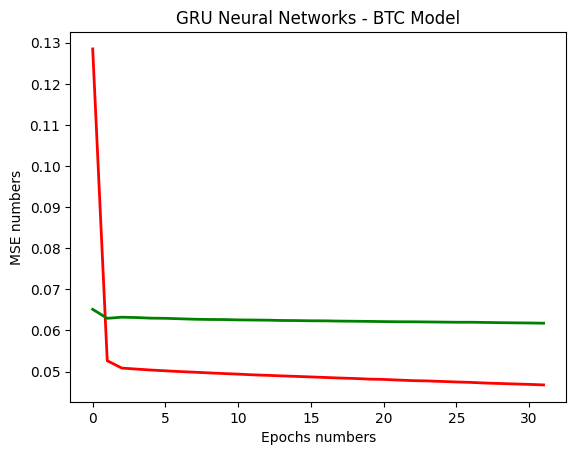

In [53]:
import matplotlib.pyplot as plt
plt.plot(models.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(models.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('GRU Neural Networks - BTC Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [54]:
from tensorflow.keras.models import load_model
model = load_model('/content/model/model_32.h5')

preds = gruMODEL.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

563/563 [==============================] - 3s 5ms/step


32229.737145977357

In [56]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

1306207683.9288485

In [57]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

-392.8645065968288

In [58]:
y_test.ravel().shape

AttributeError: 'DataFrame' object has no attribute 'ravel'

In [51]:
y_testt = scaling.inverse_transform(y_test)
print(type(y_testt))

NameError: name 'scaling' is not defined

In [52]:
preds = scaling.inverse_transform(gruMODEL.predict(X_test))

NameError: name 'scaling' is not defined

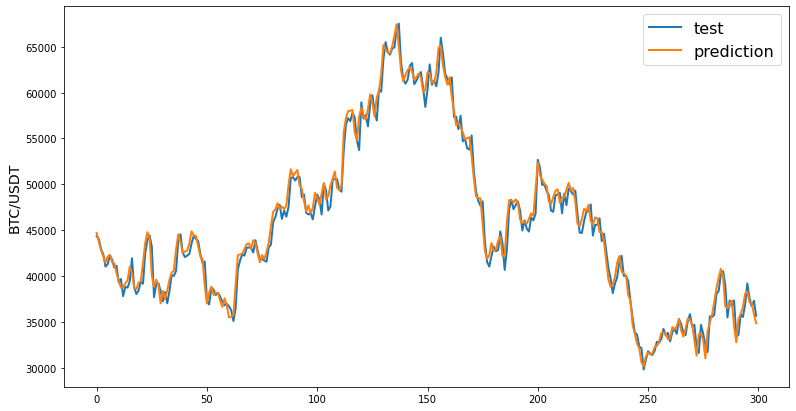

In [ ]:
line_plot(y_testt, preds, 'test', 'prediction', title='')

27 March Prediction = **46351.24609375 BTC/USDT**

27 March 02.22AM (Istanbul Time) = **46564.0000 BTC/USDT**

In [ ]:
prediction = np.array([[44331,44818,44090]])
X_testt = scaling.inverse_transform(X_test[0])
prediction_new = np.array([[(X_test[0][0]/X_testt[0]*prediction[0])]])
predictions = gruMODEL.predict(prediction_new)[0][0]
predictions = np.array([[predictions]]) * prediction[0][0] / prediction_new[0][0][0]
f"27 March Prediction is {predictions[0][0]} BTC/USDT"

'27 March Prediction is 46351.24609375 BTC/USDT'

In [ ]:
print("27 March Accuracy: ")
real = 46564
predict = predictions[0][0]
accuracy = 1- (real - predictions[0][0]) / real
print("Accuracy: {}".format(accuracy))

27 March Accuracy: 
Accuracy: 0.9954309357819345
